<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_HW3/blob/main/DL2022_HW3_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prepairing**

Toggle parts of code

In [11]:
A = True
B = True
C = True
D = True

Import google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [4]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import math
from torchvision.models import resnet50, ResNet50_Weights,resnet18,ResNet18_Weights
%cd drive/MyDrive/deep_learning/HW3
!ls
%matplotlib inline

/content/drive/.shortcut-targets-by-id/1KZZqRvYOsVtD6jug6vCwrUyHDtR2xmuK/HW3
 acc4.jpg
 CNN_MODEL.pth
 data
 DL2022-HW3-P1.ipynb
 DL2022-HW3-P2.ipynb
 loss4.jpg
 MODEL.pth
 Resnet18_Cifar10_KD.pth
 Resnet18_Cifar10_no_teacher.pth
 Resnet50_Cifar10_full.pth
 Resnet50_Cifar10_lastlayer.pth
 runs
'Shoe vs Sandal vs Boot Dataset'
 shoe-vs-sandal-vs-boot-dataset-15k-images.zip
 Test-x.txt
 Test-y.txt
 Train-x.txt
 Train-y.txt


Load CUDA on device

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


# **Load Data and preprocess**

In [6]:
data_dir = './data'
transform = transforms.Compose([transforms.Resize((224,224))
                                ,transforms.RandomHorizontalFlip()
                                ,transforms.ToTensor()
                                #,transforms.Normalize([0.51, 0.47, 0.35],[0.28, 0.25, 0.28])
                                ])
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Define general Train and eval functions

In [7]:

def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    optimizer.zero_grad()

    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 
            x = x.to(device)  
            y = y.to(device)
            p = net(x)
            loss = criterion(p, y)
            epoch_loss += float(loss)
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader,    accs_test ,loss_test ):

    epoch_loss = 0
    epoch_true = 0
    epoch_true_topfive = 0
    epoch_all = 0
    i = 0

    net.eval()

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)
            loss = criterion(p, y)
            epoch_loss += float(loss)

            # predict 
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}% ')

        accs_test.append(float(epoch_true / epoch_all))
        loss_test.append(float(epoch_loss / (i + 1)))
    return accs_test,loss_test


# **A - Train last layer and freez other layers**

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Params to learn:
	 last.0.weight
	 last.0.bias


Loss: 8.345e-01 - Acc: 74.36% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]


Epoch   1 finished in 214.31s


Loss: 7.107e-01 - Acc: 77.19% : 100%|██████████| 157/157 [00:32<00:00,  4.84it/s]


Epoch   2 finished in 203.66s


Loss: 6.631e-01 - Acc: 78.77% : 100%|██████████| 157/157 [00:31<00:00,  4.92it/s]


Epoch   3 finished in 203.06s


Loss: 6.449e-01 - Acc: 79.20% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]


Epoch   4 finished in 203.00s


Loss: 6.060e-01 - Acc: 79.99% : 100%|██████████| 157/157 [00:31<00:00,  4.93it/s]


Epoch   5 finished in 202.89s


Loss: 6.031e-01 - Acc: 80.36% : 100%|██████████| 157/157 [00:31<00:00,  4.92it/s]


Epoch   6 finished in 202.86s


Loss: 5.924e-01 - Acc: 80.28% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch   7 finished in 203.31s



Loss: 5.676e-01 - Acc: 81.18% : 100%|██████████| 157/157 [00:32<00:00,  4.90it/s]


Epoch   8 finished in 203.17s


Loss: 5.775e-01 - Acc: 80.90% : 100%|██████████| 157/157 [00:31<00:00,  4.92it/s]

Epoch   9 finished in 202.57s



Loss: 5.603e-01 - Acc: 81.19% : 100%|██████████| 157/157 [00:31<00:00,  4.92it/s]


Epoch  10 finished in 203.05s


Loss: 5.598e-01 - Acc: 81.11% : 100%|██████████| 157/157 [00:32<00:00,  4.83it/s]

Epoch  11 finished in 203.98s



Loss: 5.553e-01 - Acc: 81.45% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]


Epoch  12 finished in 204.19s


Loss: 5.431e-01 - Acc: 81.72% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]


Epoch  13 finished in 203.33s


Loss: 5.473e-01 - Acc: 81.65% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch  14 finished in 203.71s



Loss: 5.433e-01 - Acc: 81.66% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch  15 finished in 203.48s



Loss: 5.503e-01 - Acc: 81.34% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch  16 finished in 202.86s



Loss: 5.426e-01 - Acc: 81.48% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch  17 finished in 202.76s



Loss: 5.366e-01 - Acc: 81.92% : 100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


Epoch  18 finished in 203.61s


Loss: 5.370e-01 - Acc: 81.66% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch  19 finished in 202.95s



Loss: 5.364e-01 - Acc: 81.91% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]


Epoch  20 finished in 202.73s


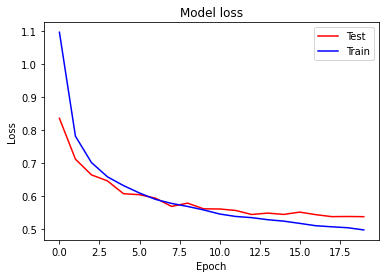

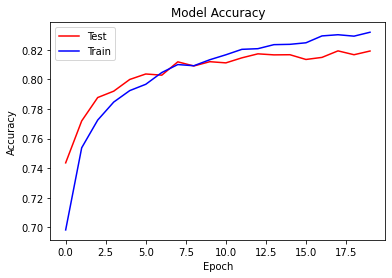

Best Accuracy :81.92%


In [8]:
if A:
  accs = []

  class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(2048, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x



  weights = ResNet50_Weights.DEFAULT
  net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  net.fc = nn.Sequential()

  for param in net.parameters():
        param.requires_grad = False

  net = lastLayer(net).to(device)

  criterion = nn.CrossEntropyLoss().to(device)

  print("Params to learn:")
  params_to_update = []
  for name,param in net.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)
          print("\t",name)

  optimizer = torch.optim.RMSprop(params_to_update, lr=2e-4)

  epochs = 20
  from time import time
  accs_train = []
  loss_train = []
  accs_test = []
  loss_test = []
  for e in range(epochs):
      start_time = time()
      accs_train,loss_train = train_epoch(net, criterion, optimizer, train_loader,accs_train,loss_train)
      accs_test,loss_test = eval_epoch(net, criterion, test_loader,accs_test,loss_test)
      if accs_test[-1]==max(accs_test):
        torch.save(net.state_dict(), 'Resnet50_Cifar10_lastlayer.pth')
      end_time = time()

      print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

  plt.plot(np.array(loss_test), 'r')
  plt.plot(np.array(loss_train), 'b')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('loss4.jpg')
  plt.show()

  plt.plot(np.array(accs_test), 'r')
  plt.plot(np.array(accs_train), 'b')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('acc4.jpg')
  plt.show()


  print(f'Best Accuracy :{max(accs_test) * 100.:.2f}%')

I could not catch an accuracy of more than 81 percent in this part.
It can be because of the stability of CNN parameters and just changing the last fully connected layer. It ran in 20 epochs, batch size 64, and learning rate 2e-4. The results are shown above.
The best model has been saved in the "Resnet50_Cifar10_lastlayer.pth" file

# **B- Train ResNet18 on CIFAR-10 with ResNet50 teacher**

Define Train and loss function

In [ ]:
def train_epoch_with_teacher(alpha,taw,student: nn.Module,teacher: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    student.train()
    optimizer.zero_grad()
    m = nn.Softmax(dim=1)
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 
            x = x.to(device)  
            y = y.to(device)

            prediction_student = student(x)
            prediction_teacher = teacher(x)

            soft_student_1 = m(prediction_student) 
            soft_student_t = m(prediction_student.divide(taw)) 
            soft_teacher = m(prediction_teacher.divide(taw)) 

            loss1 = criterion(soft_student_1, y)
            loss2 = criterion(soft_student_t, soft_teacher)

            loss = loss1.multiply(1-alpha)+loss2.multiply(alpha)

            epoch_loss += float(loss)
            predictions = prediction_student.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

def eval_epoch_with_teacher(alpha,taw,student: nn.Module,teacher: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader,    accs_test ,loss_test ):

    epoch_loss = 0
    epoch_true = 0
    epoch_true_topfive = 0
    epoch_all = 0
    i = 0
    m = nn.Softmax(dim=1)
    student.eval()

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)

            prediction_student = student(x)
            prediction_teacher = teacher(x)

            soft_student_1 = m(prediction_student) 
            soft_student_t = m(prediction_student.divide(taw)) 
            soft_teacher = m(prediction_teacher.divide(taw)) 

            loss1 = criterion(soft_student_1, y)
            loss2 = criterion(soft_student_t, soft_teacher)

            loss = loss1.multiply(1-alpha)+loss2.multiply(alpha)

            epoch_loss += float(loss)

            # predict 
            predictions = soft_student_1.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}% ')

        accs_test.append(float(epoch_true / epoch_all))
        loss_test.append(float(epoch_loss / (i + 1)))
    return accs_test,loss_test

Define Layers and set hyperparameters, then run code

Loss: 2.170e+00 - Acc: 52.80% : 100%|██████████| 157/157 [00:39<00:00,  3.93it/s]


Epoch   1 finished in 636.92s


Loss: 2.175e+00 - Acc: 51.69% : 100%|██████████| 157/157 [00:40<00:00,  3.92it/s]

Epoch   2 finished in 636.77s



Loss: 2.152e+00 - Acc: 60.22% : 100%|██████████| 157/157 [00:39<00:00,  3.93it/s]


Epoch   3 finished in 636.59s


Loss: 2.136e+00 - Acc: 64.84% : 100%|██████████| 157/157 [00:39<00:00,  3.93it/s]


Epoch   4 finished in 636.00s


Loss: 2.193e+00 - Acc: 47.96% : 100%|██████████| 157/157 [00:40<00:00,  3.92it/s]

Epoch   5 finished in 636.52s



Loss: 2.128e+00 - Acc: 68.70% : 100%|██████████| 157/157 [00:40<00:00,  3.92it/s]


Epoch   6 finished in 636.25s


Loss: 2.124e+00 - Acc: 71.09% : 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch   7 finished in 637.32s


Loss: 2.168e+00 - Acc: 57.08% : 100%|██████████| 157/157 [00:39<00:00,  3.94it/s]

Epoch   8 finished in 636.66s



Loss: 2.193e+00 - Acc: 49.97% : 100%|██████████| 157/157 [00:39<00:00,  3.94it/s]

Epoch   9 finished in 636.52s



Loss: 2.110e+00 - Acc: 77.38% : 100%|██████████| 157/157 [00:40<00:00,  3.92it/s]


Epoch  10 finished in 636.88s


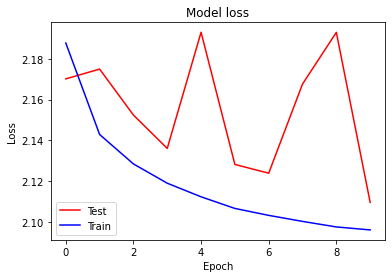

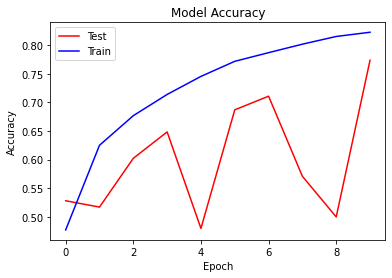

Best Accuracy :77.38%


In [ ]:
if B:  
  class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(2048, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x

  teacher = resnet50()
  teacher.fc = nn.Sequential()
  teacher = lastLayer(teacher).to(device)
  teacher.load_state_dict(torch.load("Resnet50_Cifar10_lastlayer.pth"),strict = False)
  teacher.eval()

  class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(512, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x



  student = resnet18()
  student.fc = nn.Sequential()

  student = lastLayer(student).to(device)

  criterion = nn.CrossEntropyLoss().to(device)

  params_to_update = []
  for name,param in student.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)

  optimizer = torch.optim.RMSprop(params_to_update, lr=1e-4)
  alpha = 0.9
  taw  = 4
  epochs = 10
  from time import time
  accs_train = []
  loss_train = []
  accs_test = []
  loss_test = []
  for e in range(epochs):
      start_time = time()
      accs_train,loss_train = train_epoch_with_teacher(alpha,taw,student,teacher, criterion, optimizer, train_loader,accs_train,loss_train)
      accs_test,loss_test = eval_epoch_with_teacher(alpha,taw,student,teacher, criterion, test_loader,accs_test,loss_test)
      if accs_test[-1]==max(accs_test):
        torch.save(student.state_dict(), 'Resnet18_Cifar10_KD.pth')
      end_time = time()

      print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

  plt.plot(np.array(loss_test), 'r')
  plt.plot(np.array(loss_train), 'b')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('loss4.jpg')
  plt.show()

  plt.plot(np.array(accs_test), 'r')
  plt.plot(np.array(accs_train), 'b')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('acc4.jpg')
  plt.show()
  #Nima is fucking hot
  #Nima is sexy
  #Love U Nima
  

  print(f'Best Accuracy :{max(accs_test) * 100.:.2f}%')

In the B part, we use the teacher to train and get a maximum of 77% accuracy in 10 epochs. Training this model was very time-wasting, and we could only run this in a few epochs. Alpha here was 0.9, t was 4, and the learning rate was 1e-4 with the RMSProp optimization algorithm. The best model has been saved in the 'Resnet18_Cifar10_KD.pth' file.

# **C- Train ResNet18 on CIFAR-10 without teacher**

Define particular train and eval functions

In [ ]:
def train_epoch_without_teacher(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    optimizer.zero_grad()
    m = nn.Softmax(dim=1)
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 
            x = x.to(device)  
            y = y.to(device)
            p = m(net(x))
            loss = criterion(p, y)
            epoch_loss += float(loss)
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

Run C part

Loss: 4.519e+00 - Acc: 45.72% : 100%|██████████| 157/157 [00:16<00:00,  9.53it/s]


Epoch   1 finished in 164.57s


Loss: 4.154e+00 - Acc: 40.76% : 100%|██████████| 157/157 [00:17<00:00,  9.05it/s]

Epoch   2 finished in 164.28s



Loss: 4.535e+00 - Acc: 39.57% : 100%|██████████| 157/157 [00:16<00:00,  9.65it/s]

Epoch   3 finished in 163.33s



Loss: 1.821e+00 - Acc: 62.74% : 100%|██████████| 157/157 [00:15<00:00,  9.90it/s]


Epoch   4 finished in 163.44s


Loss: 2.466e+00 - Acc: 56.17% : 100%|██████████| 157/157 [00:16<00:00,  9.53it/s]

Epoch   5 finished in 164.14s



Loss: 2.315e+00 - Acc: 62.78% : 100%|██████████| 157/157 [00:16<00:00,  9.75it/s]


Epoch   6 finished in 163.83s


Loss: 1.469e+00 - Acc: 71.98% : 100%|██████████| 157/157 [00:16<00:00,  9.65it/s]


Epoch   7 finished in 164.10s


Loss: 2.947e+00 - Acc: 62.94% : 100%|██████████| 157/157 [00:16<00:00,  9.75it/s]

Epoch   8 finished in 163.64s



Loss: 1.129e+00 - Acc: 76.06% : 100%|██████████| 157/157 [00:16<00:00,  9.59it/s]


Epoch   9 finished in 164.07s


Loss: 1.455e+00 - Acc: 72.92% : 100%|██████████| 157/157 [00:16<00:00,  9.47it/s]


Epoch  10 finished in 164.26s


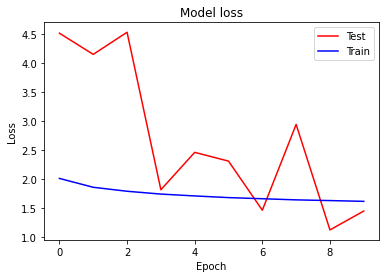

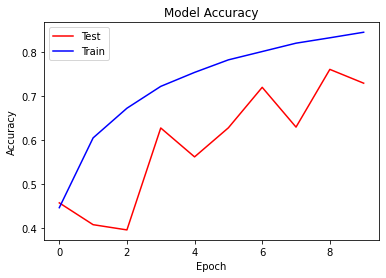

Best Accuracy :76.06%


In [ ]:
if C:
  class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(2048, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x

  teacher = resnet50()
  teacher.fc = nn.Sequential()
  teacher = lastLayer(teacher).to(device)
  teacher.load_state_dict(torch.load("Resnet50_Cifar10_lastlayer.pth"),strict = False)
  teacher.eval()

  class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(512, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x



  student = resnet18()
  student.fc = nn.Sequential()

  student = lastLayer(student).to(device)

  criterion = nn.CrossEntropyLoss().to(device)

  params_to_update = []
  for name,param in student.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)

  optimizer = torch.optim.RMSprop(params_to_update, lr=1e-4)

  epochs = 10
  from time import time
  accs_train = []
  loss_train = []
  accs_test = []
  loss_test = []
  for e in range(epochs):
      start_time = time()
      accs_train,loss_train = train_epoch_without_teacher(student, criterion, optimizer, train_loader,accs_train,loss_train)
      accs_test,loss_test = eval_epoch(student, criterion, test_loader,accs_test,loss_test)
      if accs_test[-1]==max(accs_test):
        torch.save(student.state_dict(), 'Resnet18_Cifar10_no_teacher.pth')
      end_time = time()

      print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

  plt.plot(np.array(loss_test), 'r')
  plt.plot(np.array(loss_train), 'b')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('loss4.jpg')
  plt.show()

  plt.plot(np.array(accs_test), 'r')
  plt.plot(np.array(accs_train), 'b')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('acc4.jpg')
  plt.show()


  print(f'Best Accuracy :{max(accs_test) * 100.:.2f}%')

The general growth of training, In the C part, is slower than in the B part. The best accuracy in the B part is better than in the C part. Nevertheless, parts B and C will have many differences; unfortunately, we can not train more epochs because of hardware limits.
The main reason for the difference between these two models is their different loss functions. In the B part, we have a regularization term introduced before. This term, combined with direct loss, allows our model to avoid some events, such as noise or outlier data, during the training process.
With this solution, we can get a better result in small models by this term. In fact, this term causes approximation between teacher and student models. The best model has been saved in the 'Resnet18_Cifar10_no_teacher.pth' file.

# **D- Train whole ResNet50 (all weights) on CIFAR10**

Loss: 2.722e-01 - Acc: 90.75% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]


Epoch   1 finished in 529.48s


Loss: 2.684e-01 - Acc: 91.64% : 100%|██████████| 157/157 [00:32<00:00,  4.90it/s]


Epoch   2 finished in 526.10s


Loss: 1.692e-01 - Acc: 94.45% : 100%|██████████| 157/157 [00:32<00:00,  4.85it/s]


Epoch   3 finished in 526.33s


Loss: 1.542e-01 - Acc: 95.22% : 100%|██████████| 157/157 [00:32<00:00,  4.90it/s]


Epoch   4 finished in 525.98s


Loss: 1.739e-01 - Acc: 94.74% : 100%|██████████| 157/157 [00:32<00:00,  4.83it/s]

Epoch   5 finished in 525.90s



Loss: 1.596e-01 - Acc: 95.44% : 100%|██████████| 157/157 [00:31<00:00,  4.92it/s]


Epoch   6 finished in 525.61s


Loss: 1.658e-01 - Acc: 95.31% : 100%|██████████| 157/157 [00:32<00:00,  4.86it/s]

Epoch   7 finished in 526.08s



Loss: 3.693e-01 - Acc: 91.36% : 100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Epoch   8 finished in 525.53s



Loss: 1.845e-01 - Acc: 94.85% : 100%|██████████| 157/157 [00:31<00:00,  4.93it/s]

Epoch   9 finished in 525.78s



Loss: 1.631e-01 - Acc: 95.44% : 100%|██████████| 157/157 [00:32<00:00,  4.84it/s]


Epoch  10 finished in 526.47s


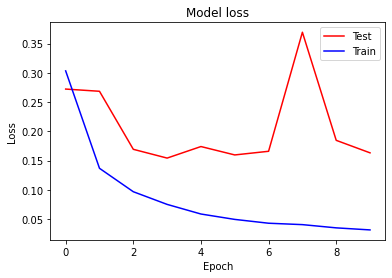

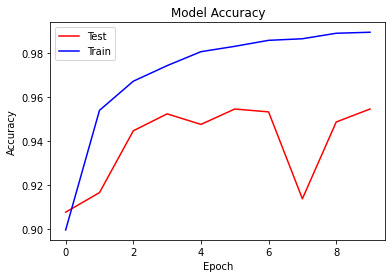

Best Accuracy :95.44%


In [13]:
if D:  
  accs = []

  class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              #nn.ReLU(inplace=True),
              nn.Linear(2048, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x


  from torchvision.models import resnet50, ResNet50_Weights
  weights = ResNet50_Weights.DEFAULT
  net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  net.fc = nn.Sequential()

  net = lastLayer(net).to(device)

  criterion = nn.CrossEntropyLoss().to(device)

  optimizer = torch.optim.RMSprop(net.parameters(), lr=2e-4)

  epochs = 10
  from time import time
  accs_train = []
  loss_train = []
  accs_test = []
  loss_test = []
  for e in range(epochs):
      start_time = time()
      accs_train,loss_train = train_epoch(net, criterion, optimizer, train_loader,accs_train,loss_train)
      accs_test,loss_test = eval_epoch(net, criterion, test_loader,accs_test,loss_test)
      if accs_test[-1]==max(accs_test):
        torch.save(net.state_dict(), 'Resnet50_Cifar10_full.pth')
      end_time = time()

      print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

  plt.plot(np.array(loss_test), 'r')
  plt.plot(np.array(loss_train), 'b')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('loss4.jpg')
  plt.show()

  plt.plot(np.array(accs_test), 'r')
  plt.plot(np.array(accs_train), 'b')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Test', 'Train'])
  plt.savefig('acc4.jpg')
  plt.show()


  print(f'Best Accuracy :{max(accs_test) * 100.:.2f}%')

ImageNet has 1000 classes, and we just want ten classes! Besides, ImageNet images have 224*224 pixel size and in CIFAR-10 size of images is 32*32, and we resized them to work properly. 
For this reason, I think tuning the last layer was not the perfect idea in this application (because of differences in CIFAR-10 and weights), and early layers should update here. 
We ran part D 10 epochs and got a much better result than the 20 epochs in part A. This happened while other parameters of both networks remained the same. The best model has been saved in the 'Resnet50_Cifar10_full.pth' file. 